In [1]:
import keras

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
#from keras.layers import CategoryEncoding
import keras_tuner as kt


import os,io

import tensorflow as tf

import chess
import chess.pgn

import random

import numpy as np

NUM_MOVES = 40 #number of moves to store in tensor

2024-12-30 09:07:39.259175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def get_ratings(game):

    return int(game.headers['WhiteElo']),int(game.headers['BlackElo'])

def rating_to_output(rating):
    ret = np.zeros(48)
    r = int((rating-600)/50)
    if r>47:
        r = 47
    if r<0:
        r = 0
    ret[r] = 1
    return ret

def get_game_tensors(game_pgn,num_tensors):

    gt = np.zeros((num_tensors,137))

    moves = []
    evals = []
    clock = []

    for m in game_pgn.mainline():
        moves.append(m.san())
        clock.append(m.clock())
        if m.eval() is None: #should only happen on a mate
            evals.append(None)
        else:
            evals.append(m.eval().white() if m.turn() == chess.WHITE else m.eval().black())

    #let our t vector be a 1D array of 130 elements. The first 128 element represent the board before the move is made and after the move is made. The 129th element is 1 if it is white moved and -1 if it is black making the move. The 130th element is the move number.

    board = chess.Board()

    for m in range(0,min(num_tensors,len(moves)-1)):
        t = np.zeros(137)

        for i in range(64): #original board position
            if board.piece_at(i) is not None:
                                t[i] = board.piece_at(i).piece_type * (1 if board.piece_at(i).color == chess.WHITE else -1)

        board.push_san(moves[m])
        for i in range(64):
            if board.piece_at(i) is not None:
                t[i+64] = board.piece_at(i).piece_type * (1 if board.piece_at(i).color == chess.WHITE else -1)

        #evals is either a number, or starts with a #. If it starts with a #, it is a mate in X moves

        #handle the case of a mate
        if evals[m] is None:
            t[129] = 0
            t[130] = 1
        if evals[m+1] is None:
            t[131] = 0
            t[132] = 1

        if evals[m] is not None and evals[m].is_mate():
            t[129] = float(evals[m].mate())
            t[130] = 1
        elif evals[m] is not None:
            t[129] = float(evals[m].score()/100)
            t[130] = 0

        if evals[m+1] is not None and evals[m+1].is_mate():
            t[131] = float(evals[m+1].mate())
            t[132] = 1
        elif evals[m+1] is not None:
            t[131] = float(evals[m+1].score()/100)
            t[132] = 0

        t[133] = -1 if board.turn == chess.WHITE else 1
        t[134] = m #record the move number
        t[135] = clock[m]
        t[136] = clock[m+1]

        gt[m] = t

    return gt

In [3]:
def extract_game(game_file,start_pos):
    #read from game_file line by line. Extract the part between [Event ...] and the next [Event ...]. Return the extracted string and the position in game_file of the start of the next game.

    game = ""
    pos = start_pos
    #seek to the start_pos
    game_file.seek(pos)
    found_start = False
    found_end = False
    
    while not found_start:
        line = game_file.readline()
        if line == "":
            #print("NULL FOUND")
            return None,None
        if line.startswith("[Event "):
            found_start = True
            game += line
    
    while not found_end:
        pos = game_file.tell()
        line = game_file.readline()
        if line.startswith("[Event ") or line == "":    
            found_end = True
        else:
            game += line

    return game,pos

def check_game(string):
    #checks if there is a string 'TimeControl "600+0"' in the game string, whether the string contains the string 'eval' and whether the string 'WhiteRatingDiff "X"' and 'BlackRatingDiff "Y"' are present and the absolute values of X and Y are less than 40.

    #print("GAME STRING:",string,"END GAME STRING")
    if string == "":
        return None

    if 'TimeControl "300+0"' in string and 'eval' in string and 'WhiteRatingDiff' in string and 'BlackRatingDiff' in string:
        white_diff = int(string.split('WhiteRatingDiff "')[1].split('"')[0])
        black_diff = int(string.split('BlackRatingDiff "')[1].split('"')[0])
        if abs(white_diff) < 40 and abs(black_diff) < 40:
            return True
        
    return False



In [4]:
def make_data(game_file,path,target_file):
    count = 0
    found_count = 0
    X,y1,y2 = [],[],[]

    with open(game_file) as f:

        pos = 0
        while True:
            game,pos = extract_game(f,pos)
            if game is None:
                break
            if check_game(game):
                #print("Found game:",game)
                game = chess.pgn.read_game(io.StringIO(game))
                gt = get_game_tensors(game,NUM_MOVES)
                y1t = get_ratings(game)[0]
                y2t = get_ratings(game)[1]

                X.append(gt)
                y1.append(y1t)
                y2.append(y2t)
                found_count += 1
                if found_count % 1000 == 0:
                    print("Found " + str(found_count) + " games")
                    np.savez_compressed(os.path.join(path,target_file + "_X.npz"),np.array(X))
                    np.savez_compressed(os.path.join(path,target_file + "_y1.npz"),np.array(y1))
                    np.savez_compressed(os.path.join(path,target_file + "_y2.npz"),np.array(y2))


            count += 1
            if count % 100000 == 0:
                print("Read " + str(count) + " games")

    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)

    #save the data to the target file
    np.savez_compressed(os.path.join(path,target_file + "_X.npz"),X)
    np.savez_compressed(os.path.join(path,target_file + "_y1.npz"),y1)
    np.savez_compressed(os.path.join(path,target_file + "_y2.npz"),y2)

def load_data(path,target_file):
    X = np.load(os.path.join(path,target_file + "_X.npz"))["arr_0"]
    y1 = np.load(os.path.join(path,target_file + "_y1.npz"))["arr_0"]
    y2 = np.load(os.path.join(path,target_file + "_y2.npz"))["arr_0"]

    return X,y1,y2

def simplify_data_no_eval(X):
    #transforms the 134 element tensor into a 131 element tensor by removing elements 129-132 and replacing them with a single element that is 1 if white is moving and -1 if black is moving and a single element that is the move number
    Xs = np.zeros((X.shape[0],X.shape[1],132))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Xs[i][j][0:64] = X[i][j][0:64]
            Xs[i][j][64:128] = X[i][j][64:128]
            Xs[i][j][128] = X[i][j][133]
            #element Xs[i][j][129] is the move number, i.e., j
            Xs[i][j][129] = j
            Xs[i][j][130] = X[i][j][135] #clock
            Xs[i][j][131] = X[i][j][136] #clock

    return Xs

def simplify_data_eval_only(X):
    #takes only elements 129-133 and adds move number
    Xs = np.zeros((X.shape[0],X.shape[1],8))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Xs[i][j][0] = X[i][j][129]
            Xs[i][j][1] = X[i][j][130]
            Xs[i][j][2] = X[i][j][131]
            Xs[i][j][3] = X[i][j][132]
            Xs[i][j][4] = X[i][j][133]
            Xs[i][j][5] = j
            Xs[i][j][6] = X[i][j][135] #clock
            Xs[i][j][7] = X[i][j][136] #clock

    return Xs

#if the data doesn't exist, generate it
if not os.path.exists("data/all_data/data_X.npz"):
    make_data("data/all_data/lichess.pgn","data/all_data/","data")

X,y1,y2 = load_data("data/all_data","data")

#X = simplify_data_eval_only(X)
#X = simplify_data_no_eval(X)

In [5]:
#we will take in our X,y1,y2 data and split it into bins of 50 rating points across y1 and y2.

def bin_data(X,y1,y2):
    bins = {}
    for i in range(len(y1)):
        bin1 = int(y1[i]/50)
        bin2 = int(y2[i]/50)
        if (bin1,bin2) not in bins:
            bins[(bin1,bin2)] = []
        
        bins[(bin1,bin2)].append((X[i],y1[i],y2[i]))
        
    return bins

def oversample(bins,num_samples):
    #pick a total of num_samples samples from the bins by selecting a bin from bins at random and then selecting a sample from that bin at random
    retX,retY1,retY2 = [],[],[]
    for i in range(num_samples):
        bin = random.choice(list(bins.keys()))
        sample = random.choice(bins[bin])
        retX.append(sample[0])
        retY1.append(sample[1])
        retY2.append(sample[2])

    return np.array(retX),np.array(retY1),np.array(retY2)
    

In [7]:
def model_builder(hp):

    #inputs = Input(shape=(NUM_MOVES, 132)) #if no eval is used
    inputs = Input(shape=(NUM_MOVES, 137)) #full tensor
    #inputs = Input(shape=(NUM_MOVES,8)) #if only the eval is used
    
    x = inputs

    #prepare hyperparameter tuning

    num_LSTM_layers = hp.Int('num_LSTM_layers',0,2)
    num_LSTM_units=[]
    for i in range(num_LSTM_layers+1):
        num_LSTM_units.append(hp.Int('lstm'+str(i)+'_units',
                                     min_value = 32,
                                     max_value = 256,
                                     step=16))
        
                                     
    num_dense_layers = hp.Int('num_dense_layers',1,3)
    num_dense_units = []
    dense_activation = []

    for i in range(num_dense_layers):
        num_dense_units.append(hp.Int('dense'+str(i)+'_units',
                                     min_value = 32,
                                     max_value = 256,
                                     step=16))
        dense_activation.append(hp.Choice("dense"+str(i)+"_activation",["relu", "selu","leaky_relu","tanh"]))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-2])

    #make the NN

    for i in range(num_LSTM_layers):
        x = LSTM(num_LSTM_units[i],return_sequences = True)(x)

    #add a final LSTM layer that doesn't return sequences
    x = LSTM(num_LSTM_units[-1])(x)
    
    for i in range(num_dense_layers):
        x = Dense(num_dense_units[i],activation = dense_activation[i])(x)


    output1 = Dense(1,activation='relu',name="WhiteElo")(x)
    output2 = Dense(1,activation='relu',name="BlackElo")(x)

    #Alternative: set outputs to be hot encoded between 48 values
    #output1 = Dense(48,activation='softmax',name="WhiteElo")(x)
    #output2 = Dense(48,activation='softmax',name="BlackElo")(x)

    model = keras.Model(inputs=inputs,outputs=[output1,output2])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss={'WhiteElo':'mae','BlackElo':'mae'},
                    metrics={'WhiteElo':'mae','BlackElo':'mae'})

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True,mode='auto',monitor='val_loss')

tuner.search(X,(y1,y2),epochs=100,validation_split=0.2,callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.values)

model = tuner.hypermodel.build(best_hps)

history = model.fit(X,(y1,y2),epochs=100,validation_split=0.2,callbacks=[stop_early,save])
model.save('model3.keras')

In [ ]:
#bins = bin_data(X,y1,y2)
#print("bins made")
#OX,Oy1,Oy2 = oversample(bins,len(X))

inputs = Input(shape=(NUM_MOVES, 137)) #full tensor
x = LSTM(80,return_sequences = True)(inputs)
x = LSTM(32)(x)
x = Dense(80,activation='relu')(x)


output1 = Dense(1,activation='relu',name="WhiteElo")(x)
output2 = Dense(1,activation='relu',name="BlackElo")(x)

modelW = keras.Model(inputs=inputs,outputs=[output1])

modelW.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'WhiteElo':'mae'},
                    metrics={'WhiteElo':'mae'})

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelO1W.keras', save_best_only=True,mode='auto',monitor='val_loss')

modelW.fit(OX,Oy1,epochs=100,validation_split=0.2,callbacks=[stop_early,save])

modelW.save('modelO1W.keras')


modelB = keras.Model(inputs=inputs,outputs=[output2])

modelB.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'BlackElo':'mae'},
                    metrics={'BlackElo':'mae'})

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelO1B.keras', save_best_only=True,mode='auto',monitor='val_loss')

modelB.fit(OX,Oy2,epochs=100,validation_split=0.2,callbacks=[stop_early,save])

modelB.save('modelO1B.keras')

Epoch 1/100
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 116s 39ms/step - loss: 952.1003 - mae: 952.1003 - val_loss: 330.2997 - val_mae: 330.2997
Epoch 2/100
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 108s 37ms/step - loss: 315.1604 - mae: 315.1604 - val_loss: 260.5688 - val_mae: 260.5688
Epoch 3/100
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 108s 37ms/step - loss: 251.3730 - mae: 251.3730 - val_loss: 235.5315 - val_mae: 235.5315
Epoch 4/100
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 111s 38ms/step - loss: 222.9726 - mae: 222.9726 - val_loss: 222.7666 - val_mae: 222.7666
Epoch 5/100
2896/2897 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 204.7387 - mae: 204.7387

In [ ]:
inputs = Input(shape=(NUM_MOVES, 137)) #full tensor
x = LSTM(80,return_sequences = True)(inputs)
x = LSTM(34)(x)
x = Dense(82,activation='relu')(x)

output1 = Dense(1,activation='relu',name="WhiteElo")(x)
output2 = Dense(1,activation='relu',name="BlackElo")(x)

model = keras.Model(inputs=inputs,outputs=[output1,output2])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'WhiteElo':'mae','BlackElo':'mae'},
                    metrics={'WhiteElo':'mae','BlackElo':'mae'})

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('model2.keras', save_best_only=True,mode='auto',monitor='val_loss')

model.fit(X,(y1,y2),epochs=100,validation_split=0.2,callbacks=[stop_early,save])

In [57]:
def analyse_game(file,model):
    with open(file) as f:
        game,pos = extract_game(f,0)
        game = chess.pgn.read_game(io.StringIO(game))
        gt = get_game_tensors(game,NUM_MOVES)

        print(gt.shape)
        #gt = simplify_data_no_eval(gt)
        #gt = simplify_data_eval_only(gt)
        return model(np.array([gt]),training=False)
    
model = keras.models.load_model('model2.keras')

print(analyse_game("data/all_data/2200.pgn",model))

(40, 137)
[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1929.3486]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1925.526]], dtype=float32)>]


In [6]:
from keras.layers import TimeDistributed

inputs = Input(shape=(NUM_MOVES, 137)) #full tensor

#make a dense layer for each of the NUM_MOVES elements. The output of each dense layer is a 1D tensor of 137 elements. Each of these tensors is then concatenated to form a 2D tensor of 137xNUM_MOVES elements. This tensor is then fed into an LSTM layer.

x = TimeDistributed(Dense(130,activation = 'leaky_relu'))(inputs)

x = LSTM(80,return_sequences = True)(x)
x = LSTM(32)(x)
x = Dense(60,activation='relu')(x)

output1 = Dense(1,activation='relu',name="WhiteElo")(x)
output2 = Dense(1,activation='relu',name="BlackElo")(x)

#model = keras.Model(inputs=inputs,outputs=[output1,output2])

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
#                    loss={'WhiteElo':'mae','BlackElo':'mae'},
#                    metrics={'WhiteElo':'mae','BlackElo':'mae'})

modelW = keras.Model(inputs=inputs,outputs=[output1])

modelW.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'WhiteElo':'mae'},
                    metrics={'WhiteElo':'mae'})


modelB = keras.Model(inputs=inputs,outputs=[output2])

modelB.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss={'BlackElo':'mae'},
                    metrics={'BlackElo':'mae'})


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save = tf.keras.callbacks.ModelCheckpoint('modelOTW.keras', save_best_only=True,mode='auto',monitor='val_loss')

bins = bin_data(X,y1,y2)
print("bins made")
OX,Oy1,Oy2 = oversample(bins,len(X))


#model.fit(X,(y1,y2),epochs=100,validation_split=0.2,callbacks=[stop_early,save])
modelW.fit(OX,Oy1,epochs=100,validation_split=0.2,callbacks=[stop_early,save])
modelB.fit(OX,Oy1,epochs=100,validation_split=0.2,callbacks=[stop_early,save])

bins made
Epoch 1/100
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 135s 45ms/step - BlackElo_loss: 1062.6196 - BlackElo_mae: 1062.6198 - WhiteElo_loss: 1676.3533 - WhiteElo_mae: 1676.3533 - loss: 2738.9702 - val_BlackElo_loss: 400.4082 - val_BlackElo_mae: 400.3332 - val_WhiteElo_loss: 1677.0237 - val_WhiteElo_mae: 1676.9172 - val_loss: 2077.2517
Epoch 2/100
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 126s 44ms/step - BlackElo_loss: 390.8853 - BlackElo_mae: 390.8853 - WhiteElo_loss: 1675.2872 - WhiteElo_mae: 1675.2872 - loss: 2066.1704 - val_BlackElo_loss: 346.6739 - val_BlackElo_mae: 346.5921 - val_WhiteElo_loss: 1677.0237 - val_WhiteElo_mae: 1676.9172 - val_loss: 2023.5093
Epoch 3/100
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 117s 40ms/step - BlackElo_loss: 322.4926 - BlackElo_mae: 322.4926 - WhiteElo_loss: 1676.0620 - WhiteElo_mae: 1676.0620 - loss: 1998.5541 - val_BlackElo_loss: 276.2462 - val_BlackElo_mae: 276.2498 - val_WhiteElo_loss: 1677.0237 - val_WhiteElo_mae: 1676.9172 - val_loss: 1953.1663
Epoch 4/100
2897/2897 

KeyboardInterrupt: 

                   0
count  115872.000000
mean     1675.814053
std       469.983165
min       772.000000
25%      1291.000000
50%      1677.000000
75%      2060.000000
max      2686.000000
                   0
count  115872.000000
mean     1592.375000
std       291.191491
min       772.000000
25%      1387.000000
50%      1599.000000
75%      1799.000000
max      2686.000000


(array([1759., 1323., 1513.,  958., 1897., 2411., 1896., 2752., 2696.,
        2576., 2460., 2743., 2579., 2477., 2974., 2663., 3224., 2555.,
        2761., 2925., 2477., 3155., 3334., 2680., 3160., 2969., 2869.,
        2851., 2818., 3023., 2737., 2936., 3030., 2885., 2563., 2380.,
        2584., 3051., 3043., 1990., 2378., 1750., 2466., 1407., 1261.,
        1092., 1230.,  118.,  383.,  110.]),
 array([ 772.  ,  810.28,  848.56,  886.84,  925.12,  963.4 , 1001.68,
        1039.96, 1078.24, 1116.52, 1154.8 , 1193.08, 1231.36, 1269.64,
        1307.92, 1346.2 , 1384.48, 1422.76, 1461.04, 1499.32, 1537.6 ,
        1575.88, 1614.16, 1652.44, 1690.72, 1729.  , 1767.28, 1805.56,
        1843.84, 1882.12, 1920.4 , 1958.68, 1996.96, 2035.24, 2073.52,
        2111.8 , 2150.08, 2188.36, 2226.64, 2264.92, 2303.2 , 2341.48,
        2379.76, 2418.04, 2456.32, 2494.6 , 2532.88, 2571.16, 2609.44,
        2647.72, 2686.  ]),
 <BarContainer object of 50 artists>)

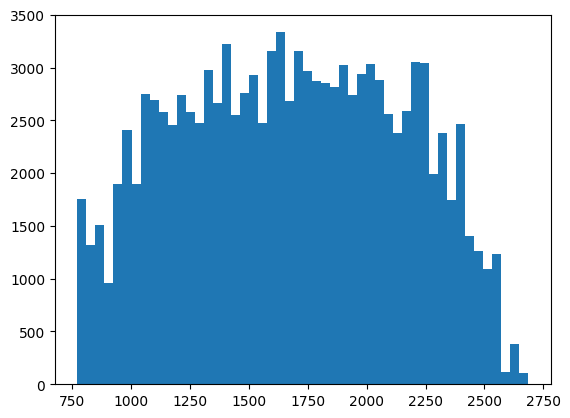

In [16]:
import pandas as pd

df = pd.DataFrame(Oy1)
print(df.describe())

df = pd.DataFrame(y1)
print(df.describe())

#plot the distribution of the ratings
import matplotlib.pyplot as plt

plt.hist(Oy1,bins=50)

In [85]:
len(tf.keras.utils.to_categorical(y1,num_classes=48))

IndexError: index 1950 is out of bounds for axis 1 with size 48

In [78]:
y1.shape

(115872,)